In [1]:
import torch

#### Get scale using symmetric mode
s = rmax / qmax

In [6]:
def get_q_scale_symmetric(tensor, dtype=torch.int8):
  r_max = tensor.abs().max().item()
  q_max = torch.iinfo(dtype).max
  scale = r_max / q_max
  return scale

In [3]:
# defind 4x4 test sensor
test_tensor = torch.randn(4, 4)
print(test_tensor)


tensor([[-1.2092,  1.7717,  1.0831,  0.9463],
        [ 0.3946, -0.2911,  1.3147, -1.0093],
        [-1.4428, -0.0523, -0.0459,  1.4197],
        [-2.4651,  0.6037, -0.7920,  0.8039]])


In [7]:
scale = get_q_scale_symmetric(test_tensor)
print(scale)

0.019410491928340882


#### Calculating Quantized Tensors
which is q = int(round(r/s))

In [13]:
from helpers import linear_q_with_scale_and_zeropoint
def linear_q_symmetric(tensor, dtype=torch.int8):
  scale = get_q_scale_symmetric(tensor, dtype)
  q_tensor = linear_q_with_scale_and_zeropoint(tensor, scale, 0, dtype)
  return q_tensor, scale

In [9]:
q_tensors, scale = linear_q_symmetric(test_tensor)
print(q_tensors)

tensor([[ -62,   91,   56,   49],
        [  20,  -15,   68,  -52],
        [ -74,   -3,   -2,   73],
        [-127,   31,  -41,   41]], dtype=torch.int8)


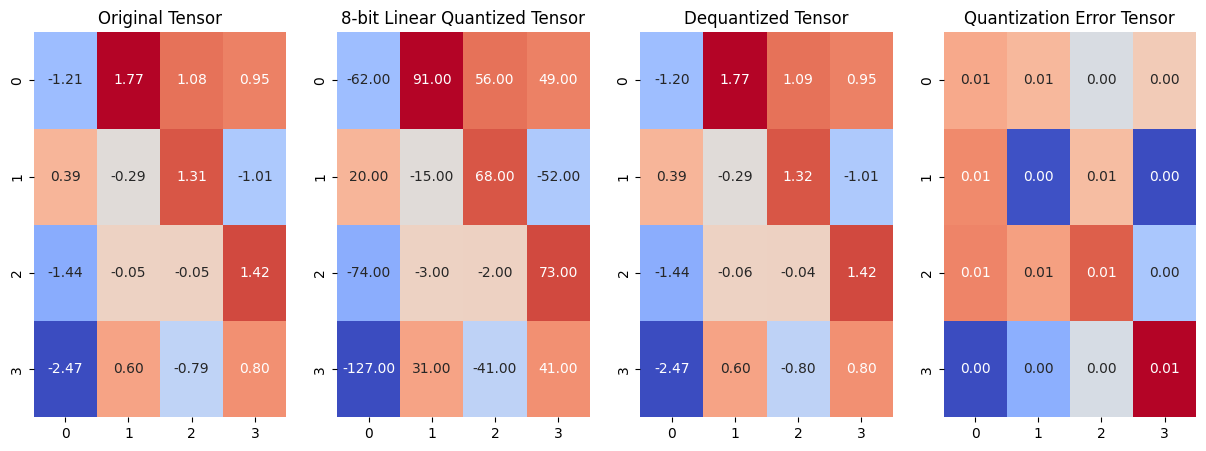

In [19]:
from helpers import calculate_dequantization_error, plot_tensors

def linear_dequantizer(q_tensor, scale, zeropoint):
    return scale * (q_tensor.float() - zeropoint)

dequantized_tensor = linear_dequantizer(q_tensors, scale, 0)
quantization_error = calculate_dequantization_error(test_tensor, dequantized_tensor)

plot_tensors(test_tensor,q_tensors, dequantized_tensor, quantization_error)

In [20]:
error = quantization_error.square().mean()
print(error)

tensor(2.4155e-05)


### Per Channel Quantization

We will store the scale and zero point per row and column based on which axis we chose to quantize along.
- the memory needed to store the parameters per channel is pretty small
- This granularity is used when we're quantizing in 8bits

In [21]:
dim = 0 # dimension to calculate the scale and zero point along the rows, 1 for columns
output_dim = test_tensor.shape[dim]
print(output_dim)

4


We want to store scales per channel(row)

In [23]:
# define a zero tensor
scale = torch.zeros(output_dim)
print(scale)

tensor([0., 0., 0., 0.])


In [25]:
# iterate over the output dimension
for idx in range(output_dim):
  sub_tensor = test_tensor.select(dim, idx)
  scale[idx] = get_q_scale_symmetric(sub_tensor)
  

In [26]:
scale

tensor([0.0140, 0.0104, 0.0114, 0.0194])

Preprocess the scale so that when we divide the original tensor by the scale, we divide each row with the correct scale

In [29]:

# define scale shape
scale_shape = [1] * test_tensor.dim()
print("original scale shape: ",scale_shape)
scale_shape[dim] = -1
print("defined shape", scale_shape)

original scale shape:  [1, 1]
defined shape [-1, 1]


In [30]:
# reshape the scale tensor
scale = scale.view(scale_shape)
print(scale)

tensor([[0.0140],
        [0.0104],
        [0.0114],
        [0.0194]])


this is the shape we need to divide the original tensor appropriately with our scale tensor(this is tensor by tensor division that led us to make sure they are in a shape where they can be divided appropriately)

In [33]:
print("tensor shape: ", test_tensor.shape)
print("scale shape: ", scale.shape)
print("They are divisible: ", test_tensor.shape[dim] == scale.shape[dim])
q_tensor_channel = linear_q_with_scale_and_zeropoint(test_tensor, scale, 0)
print(q_tensor_channel)

tensor shape:  torch.Size([4, 4])
scale shape:  torch.Size([4, 1])
They are divisible:  True
tensor([[ -87,  127,   78,   68],
        [  38,  -28,  127,  -98],
        [-127,   -5,   -4,  125],
        [-127,   31,  -41,   41]], dtype=torch.int8)


In [34]:
# put everything together
def linear_q_symmetric_per_channel(tensor, axis, dtype=torch.int8):
  output_dim = tensor.shape[axis]
  scale = torch.zeros(output_dim)
  for idx in range(output_dim):
    sub_tensor = tensor.select(axis, idx)
    scale[idx] = get_q_scale_symmetric(sub_tensor)
  scale_shape = [1] * tensor.dim()
  scale_shape[axis] = -1
  scale = scale.view(scale_shape)
  q_tensor = linear_q_with_scale_and_zeropoint(tensor, scale, 0, dtype)
  return q_tensor, scale

In [38]:
# get the quantized tensor per channels
q_tensor_0, scale_0 = linear_q_symmetric_per_channel(test_tensor, axis=0)
q_tensor_1, scale_1 = linear_q_symmetric_per_channel(test_tensor, axis=1)

print("scale 0: ", scale_0)
print("scale 1: ", scale_1)


scale 0:  tensor([[0.0140],
        [0.0104],
        [0.0114],
        [0.0194]])
scale 1:  tensor([[0.0194, 0.0140, 0.0104, 0.0112]])


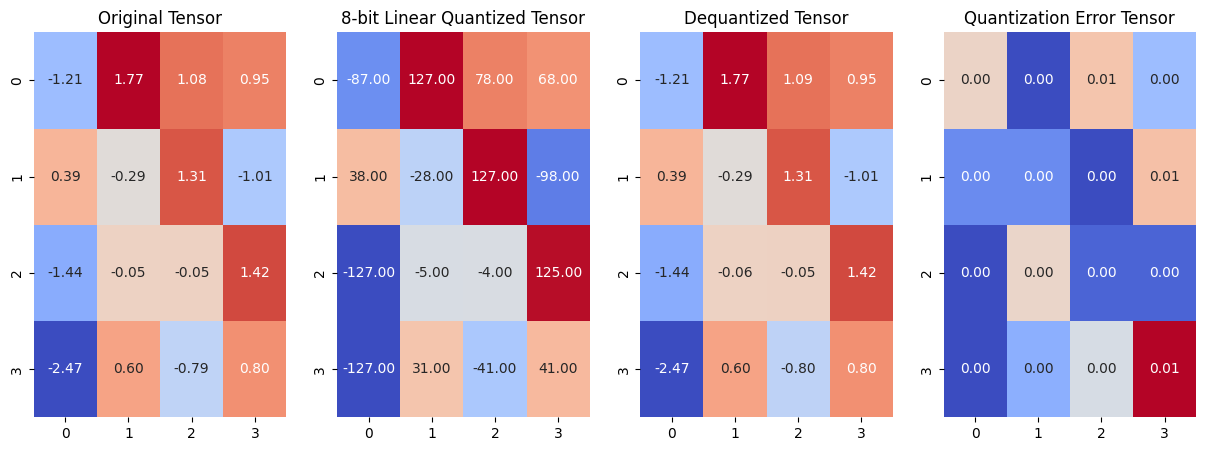

In [43]:
# Summarize the quantization along the rows
d_tensor_0 = linear_dequantizer(q_tensor_0, scale_0, 0)
quantization_error_0 = calculate_dequantization_error(test_tensor, d_tensor_0)
plot_tensors(test_tensor, q_tensor_0, d_tensor_0, quantization_error_0)

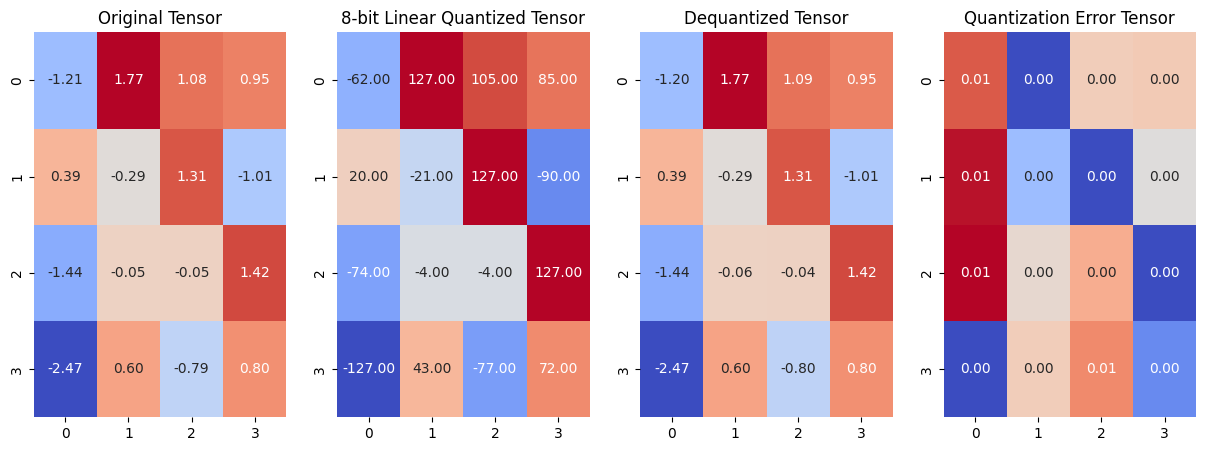

In [44]:
# Summarize the quantization along the columns
d_tensor_1 = linear_dequantizer(q_tensor_1, scale_1, 0)
quantization_error_1 = calculate_dequantization_error(test_tensor, d_tensor_1)
plot_tensors(test_tensor, q_tensor_1, d_tensor_1, quantization_error_1)

In [42]:
print("quantization error at dim 0(along the row): ", quantization_error_0.square().mean())
print("quantization error at dim 1(along the column): ", quantization_error_1.square().mean())

quantization error at dim 0(along the row):  tensor(1.1596e-05)
quantization error at dim 1(along the column):  tensor(1.4577e-05)


We can see that the quantization error decrease from per tensor q_error (2.415)
to 1.15 and 1.45 respectively for per channel quantization

### Per Group Quantization
This require alot of memories
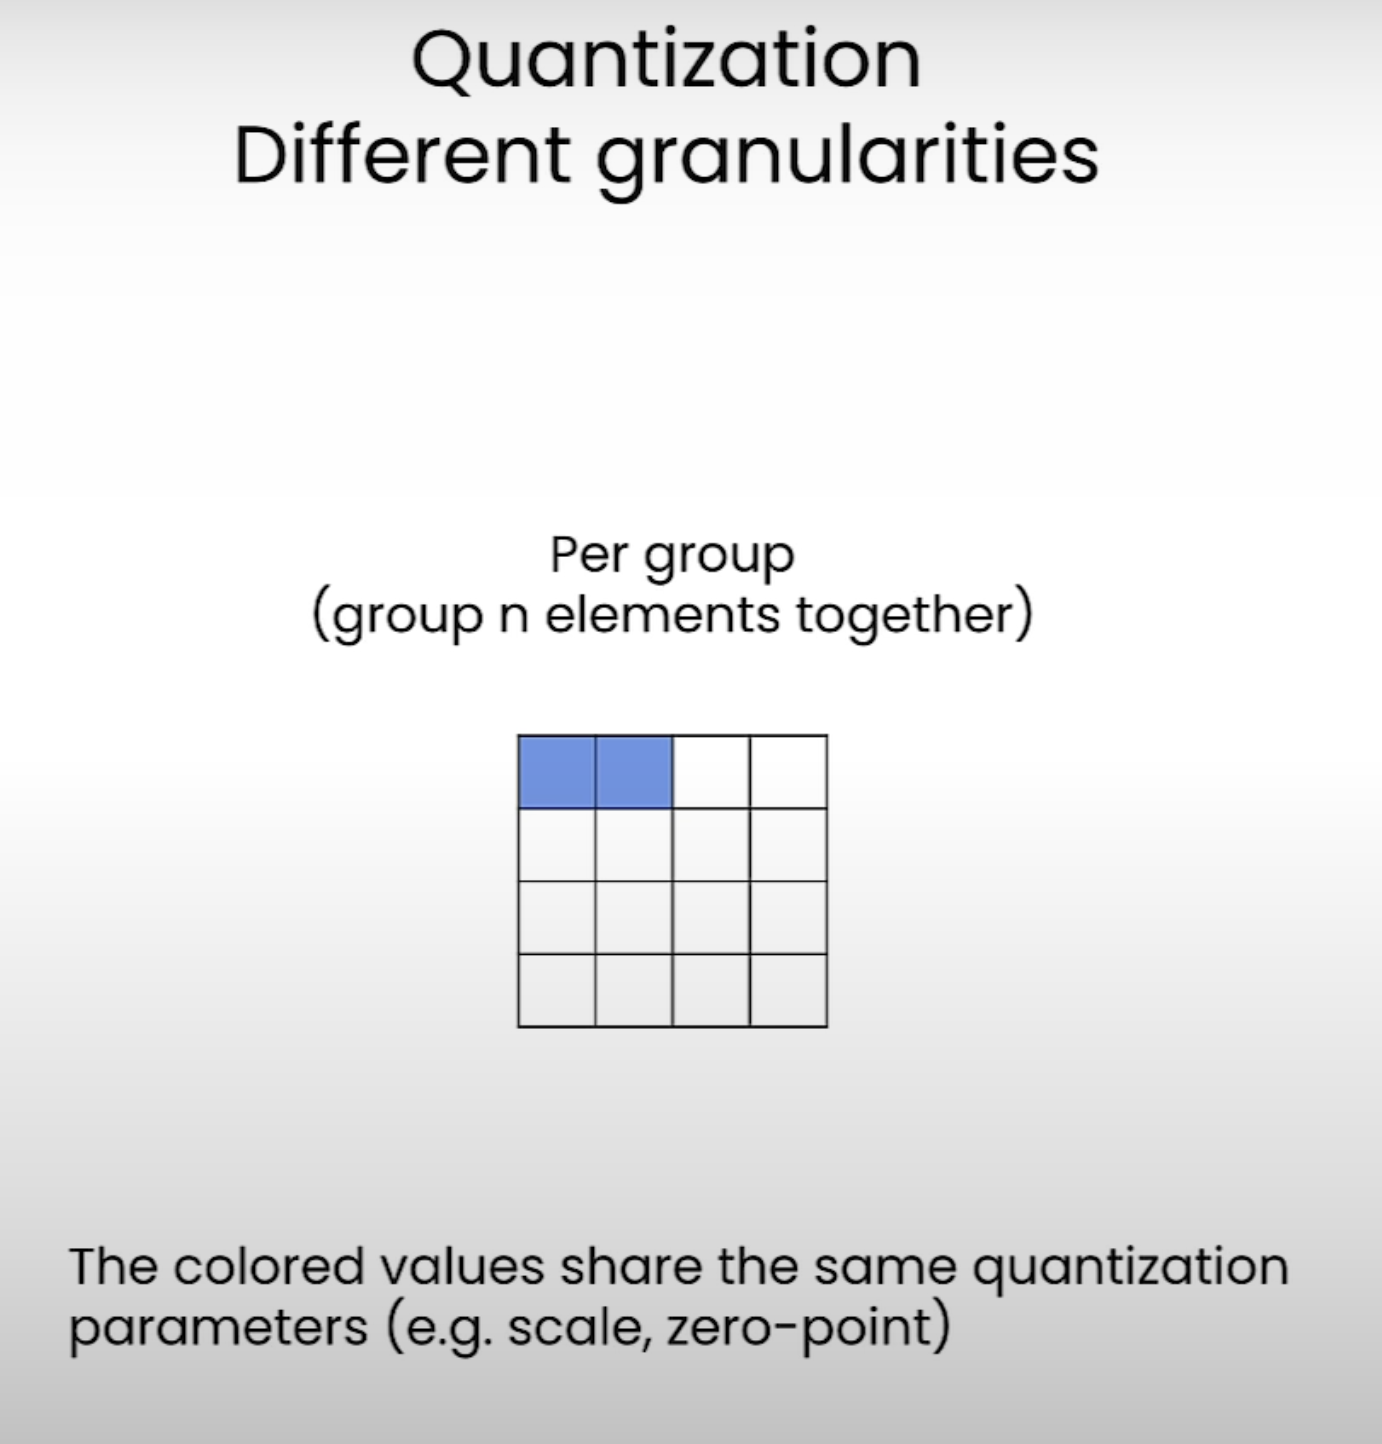

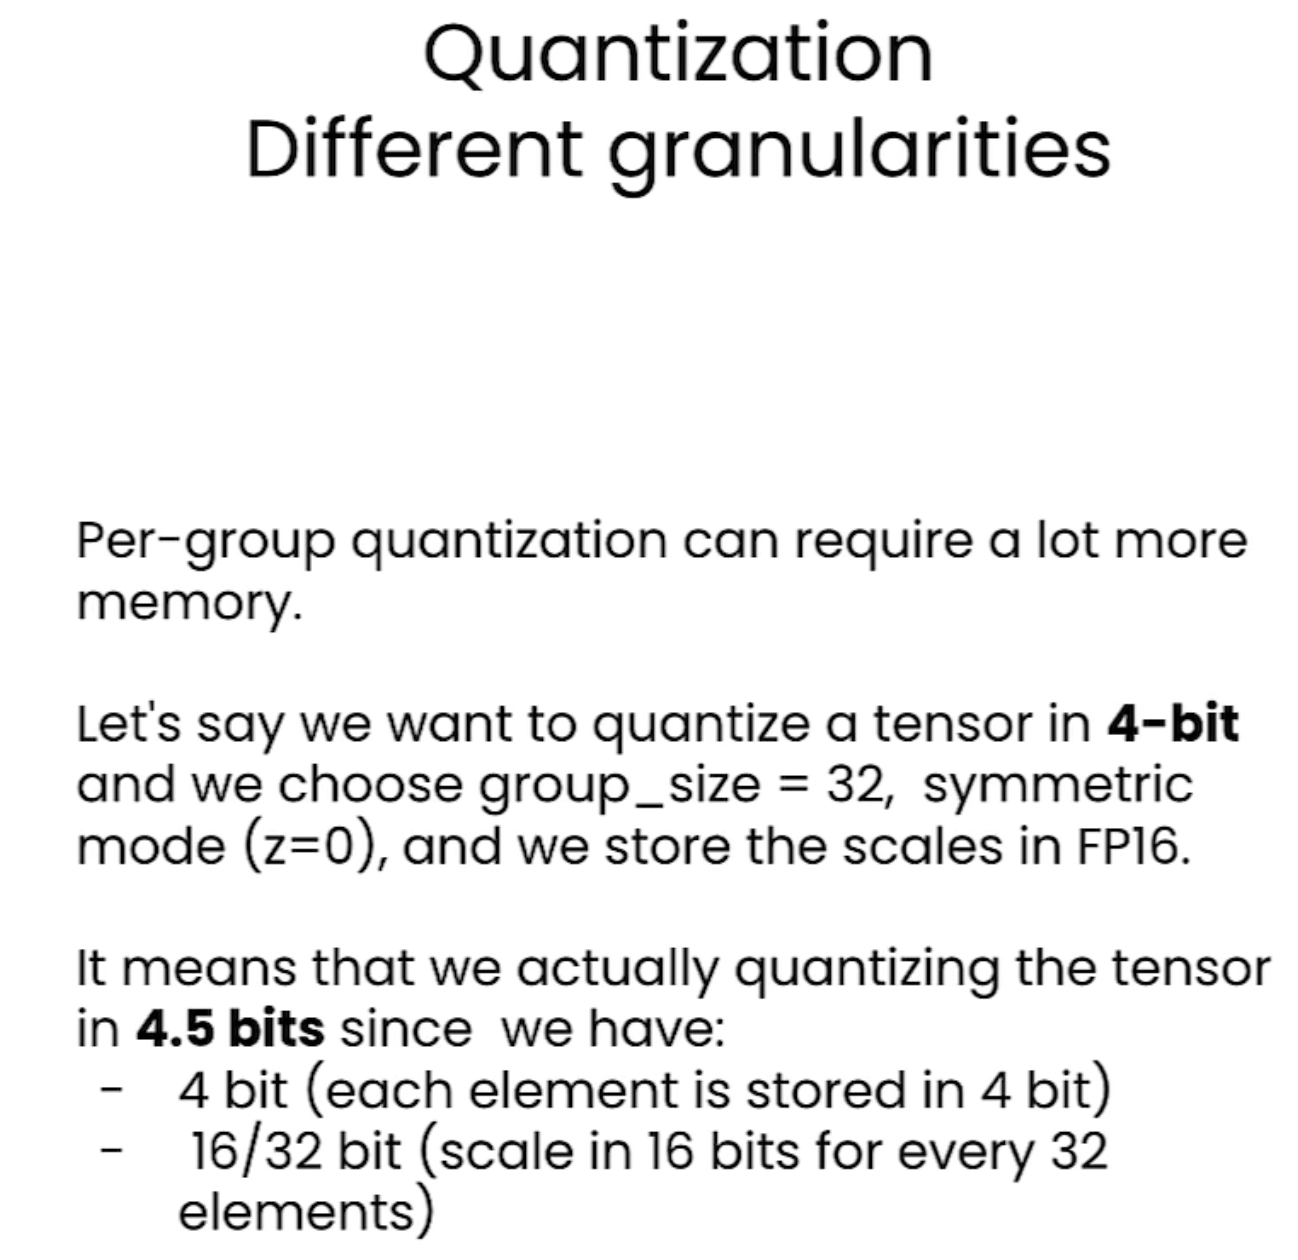

In [45]:
def linear_q_symmetric_per_group(tensor, group_size, dtype=torch.int8):
  t_shape = tensor.shape
  assert t_shape[0] % group_size == 0, "The first dimension must be divisible by the group size"
  # restrict ourselves to dim 2
  assert tensor.dim() == 2, "Only 2D tensors are supported"
  # reshape the tensor
  tensor = tensor.view(-1, group_size)
  # calculate the scale
  q_tensor, scale = linear_q_symmetric_per_channel(tensor, axis=0, dtype=dtype)
  # reshape the quantized tensor to its original shape
  q_tensor = q_tensor.view(t_shape)
  return q_tensor, scale

In [47]:
def linear_d_per_group(q_tensor, scale, group_size):
  q_shape = q_tensor.shape
  q_tensor = q_tensor.view(-1, group_size)
  d_tensor = linear_dequantizer(q_tensor, scale, 0)
  d_tensor = d_tensor.view(q_shape)
  return d_tensor

In [53]:
test_tensor = torch.randn(6, 6)
group_size = 3
q_tensor, scale = linear_q_symmetric_per_group(test_tensor, group_size)
d_tensor = linear_d_per_group(q_tensor, scale, group_size)
quantization_error = calculate_dequantization_error(test_tensor, d_tensor)
plot_tensors(test_tensor, q_tensor, d_tensor, quantization_error)

AssertionError: The first dimension must be divisible by the group size

In [52]:
print("quantization error Per group: ", quantization_error.square().mean())

quantization error Per group:  tensor(5.8859e-06)
